# Analysis of Cross-Sectional Data

Linear regression is an essential tool of any econometrician and is widely used throughout finance and economics. Linear regression’s success is owed to two key features: the availability of simple, closed-form estimators, and the ease and directness of interpretation.

## Model Description

$$Y = X \beta + \varepsilon$$

With the following assumptions:

* $E(\varepsilon) = 0 $
* $V(\varepsilon) = \sigma^2 I$ (covariance stationary)
* $X$ is nonstochastic fix full rank $K$

**OLS Estimator**: $\hat{\beta} = (X'X)^{-1} X'y$

**OLS Variance Estimator**: 

$$ \hat{\sigma}^2 = \frac{ \hat{\varepsilon}' \hat{\varepsilon} } {n-k}$$

The main assumptions are:

* Linearity
* conditional mean is zero
* conditional homoskedasticity ($\sigma^2$)
* conditional normality
* X is full rank

What does the heteroscedasticity mean?

The disturbance in matrix A is homoskedastic; this is the simple case where OLS is the best linear unbiased estimator. The disturbances in matrices B and C are heteroskedastic. In matrix B, the variance is time-varying, increasing steadily across time; in matrix C, the variance depends on the value of x. The disturbance in matrix D is homoskedastic because the diagonal variances are constant, even though the off-diagonal covariances are non-zero and ordinary least squares is inefficient for a different reason: serial correlation.

$$A = \sigma^2 \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} \ \ \ B = \sigma^2 \begin{bmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 3 \end{bmatrix} $$ 
$$C = \sigma^2 \begin{bmatrix} x_1 & 0 & 0 \\ 0 & x_2 & 0 \\ 0 & 0 & x_3 \end{bmatrix} \ \ \ D = \sigma^2 \begin{bmatrix} 1 & \rho & \rho^2 \\ \rho & 1 & \rho \\ \rho^2 & \rho & 1 \end{bmatrix}$$

An alternative to modeling heteroskedastic data is to transform the data so that is is homoskedastic using generalized least squares (GLS). GLS extends OLS to allow for arbitrary weighting matrices. The GLS estimator of β is defined: 

$$\hat{\beta}^{GLS} = (X'W^{-1}X)^{-1} X' W^{-1} y$$

for some positive definite matrix W. The full value of GLS is only realized when $W$ is wisely chosen. 

We could also use maximum likelihood to estimate the coefficient. It is important to note that the derivation of the OLS estimator does not require an assumption of normality. Moreover, the unbiasedness, variance, and BLUE properties do not rely on the conditional normality of residuals.  


T-tests can be used to test a single hypothesis involving one or more coefficient. 

In linear factors models, Fama and French (1992) use returns on specially constructed portfolios as factors to capture specific types of risk. We will first study Fama French 3-factor model and then move to the models with more factors. 

The traditional asset pricing model, known formally as the capital asset pricing model (CAPM) uses only one variable to describe the returns of a portfolio or stock with the returns of the market as a whole. In contrast, the Fama–French model uses three variables. Fama and French started with the observation that two classes of stocks have tended to do better than the market as a whole: (i) small caps and (ii) stocks with a high book-to-market ratio (B/P, customarily called value stocks, contrasted with growth stocks).

They then added two factors to CAPM to reflect a portfolio's exposure to these two classes:

$$r = R_f + \beta(R_m - R_f) + b_s \cdot SMB + b_v \cdot HML + +\alpha + \epsilon$$

Or we could write it as:

$$r - R_f = \alpha +  \beta(R_m - R_f) + b_s \cdot SMB + b_v \cdot HML + \epsilon $$

We will use the dataset from Fama and French, which you could download [here](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In [203]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.api import VAR

In [55]:
# a function of reading and cleaning dataset
def read_fama_french(file):
    df = (pd.read_csv(file, skiprows=2)  # skip the first two rows
             .iloc[0:1136, :]  # select certain rows
             .set_index('Unnamed: 0')
             .rename_axis(None)  # remove the name of axis
         )
    df.index = pd.to_datetime(df.index, format="%Y%m")  # convert to datetime
    df = df.astype('float')
    return df

In [56]:
ff_monthly = read_fama_french('../data/ThreeFactorsMonthly.CSV')

In [57]:
ff_monthly.tail()

,Mkt-RF,SMB,HML,RF
2020-10-01,-2.10,4.44,4.03,0.01
2020-11-01,12.47,5.48,2.11,0.01
2020-12-01,4.63,4.81,-1.36,0.01
2021-01-01,-0.04,7.19,2.85,0.00
2021-02-01,2.79,2.11,7.07,0.00


<AxesSubplot:>

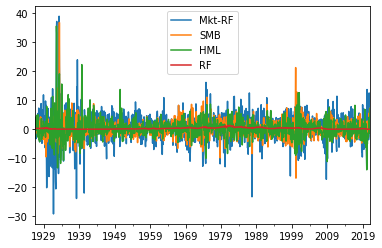

In [58]:
ff_monthly.plot()

<AxesSubplot:>

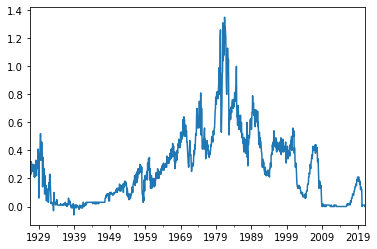

In [79]:
ff_monthly['RF'].plot()

### Descriptive Statistics

Now, we would construct a dataset consisting of monthly observations from 1980 to 2019. And we will use it to predict fund returns of "FCNTX". Before we run the regression, we have to math the timeline first.

In [123]:
def get_return_data(ticker, start_date, end_date, period="M"):
    daily_price = pdr.data.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close']
    resample_price = daily_price.resample(period).ffill().dropna()
    rtn = resample_price.pct_change().dropna()
    
    return rtn

In [134]:
start_date = '1980-01-01'  # to math the timeline
end_date = '2019-12-31'

In [135]:
ticker = "FCNTX"
fcntx_return = get_return_data(ticker, start_date, end_date) * 100  # express it in the percentage format 

In [136]:
fcntx_return.head()

Date
1980-02-29   -1.687411
1980-03-31   -8.943086
1980-04-30    1.785707
1980-05-31    7.894740
1980-06-30    1.174350
Freq: M, Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

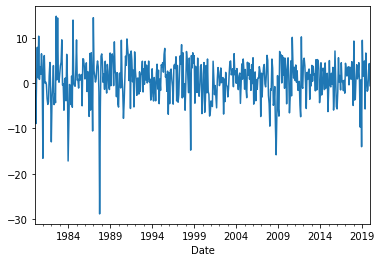

In [137]:
fcntx_return.plot()

In [138]:
dataset = ff_monthly.loc['1980-02-01':end_date]
dataset.head()

,Mkt-RF,SMB,HML,RF
1980-02-01,-1.22,-1.83,0.66,0.89
1980-03-01,-12.90,-6.65,-1.02,1.21
1980-04-01,3.97,0.96,1.01,1.26
1980-05-01,5.26,2.16,0.38,0.81
1980-06-01,3.06,1.66,-0.85,0.61


In [139]:
fcntx_return.shape[0] == dataset.shape[0]  # check weather we have the same lenght

True

In [151]:
# join the two dataset
dataset['fcntx'] = fcntx_return.values
dataset['fcntx_excess'] = dataset['fcntx'] - dataset['RF']
dataset.head()

<ipython-input-151-54746ba13b2e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['fcntx'] = fcntx_return.values
<ipython-input-151-54746ba13b2e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['fcntx_excess'] = dataset['fcntx'] - dataset['RF']


,Mkt-RF,SMB,HML,RF,fcntx,fcntx_excess
1980-02-01,-1.22,-1.83,0.66,0.89,-1.687411,-2.577411
1980-03-01,-12.90,-6.65,-1.02,1.21,-8.943086,-10.153086
1980-04-01,3.97,0.96,1.01,1.26,1.785707,0.525707
1980-05-01,5.26,2.16,0.38,0.81,7.894740,7.084740
1980-06-01,3.06,1.66,-0.85,0.61,1.174350,0.564350


In [153]:
dataset.tail()

,Mkt-RF,SMB,HML,RF,fcntx,fcntx_excess
2019-08-01,-2.58,-2.40,-4.85,0.16,-1.804510,-1.964510
2019-09-01,1.43,-1.05,6.77,0.18,-1.531399,-1.711399
2019-10-01,2.06,0.24,-1.88,0.15,2.799383,2.649383
2019-11-01,3.87,0.91,-2.05,0.12,4.311647,4.191647
2019-12-01,2.77,0.67,1.91,0.14,-0.580130,-0.720130


In [156]:
dataset = dataset.rename({'Mkt-RF': 'mkt_excess'}, axis=1)

In [157]:
describe(dataset)

,mkt_excess,SMB,HML,RF,fcntx,fcntx_excess
nobs,4.790000e+02,4.790000e+02,4.790000e+02,4.790000e+02,4.790000e+02,4.790000e+02
missing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
mean,6.691441e-01,6.686848e-02,2.332985e-01,3.449061e-01,7.252929e-01,3.803868e-01
std_err,9.181560e-03,6.218420e-03,6.119860e-03,6.090495e-04,9.681424e-03,9.725063e-03
upper_ci,6.871396e-01,7.905636e-02,2.452932e-01,3.460998e-01,7.442681e-01,3.994476e-01
lower_ci,6.511485e-01,5.468060e-02,2.213038e-01,3.437123e-01,7.063176e-01,3.613260e-01
std,4.397967e+00,2.978623e+00,2.931413e+00,2.917347e-01,4.637402e+00,4.658305e+00
iqr,5.375000e+00,3.420000e+00,3.160000e+00,4.000000e-01,5.381121e+00,5.335772e+00
iqr_normal,3.984493e+00,2.535250e+00,2.342512e+00,2.965204e-01,3.989031e+00,3.955413e+00
mad,3.305262e+00,2.151878e+00,2.163039e+00,2.343944e-01,3.428130e+00,3.444757e+00


In [159]:
# run Fama French 3 factor model
ff_model = smf.ols('fcntx_excess ~ mkt_excess + SMB + HML', data=dataset).fit()
ff_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fcntx_excess   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     415.7
Date:                Tue, 30 Mar 2021   Prob (F-statistic):          2.12e-132
Time:                        14:28:26   Log-Likelihood:                -1107.7
No. Observations:                 479   AIC:                             2223.
Df Residuals:                     475   BIC:                             2240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1836      0.114     -1.606      0.109      -0.408       0.041
mkt_excess     0.8785      0.027     32.672      0.000       0.826       0.931
SMB            0.0088      0.040      0.221      0.825      -0.069       0.087
HML           -0.1050      0.041     -2.579      0.010      -0.185      -0.025
==============================================================================
Omnibus:                      224.933   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1607.123
Skew:                          -1.905   Prob(JB):                         0.00
Kurtosis:                      11.124   Cond. No.                         4.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**coefficient of SMB** is not significant from zero. One could see why it is like that when we do the model assessment. 

The Fama-French three-factor model (in future uses – the Fama-French model) pays attention to three major factors:

* market risk
* company size
* value factors

The main factors driving expected returns are sensitivity to the market, sensitivity to size, and sensitivity to value stocks, as measured by the book-to-market ratio. 

HML accounts for the spread in returns between value stocks and growth stocks and argues that companies with high book-to-market ratios, also known as value stocks, outperform those with lower book-to-market values, known as growth stocks.

In this model, the coefficient of HML is negative, which indicates the manager of fcntx might not rely on the value premium to earn an abnormal return, by investing in stocks with relative low book-to-market ratios.

### Assessing Fit

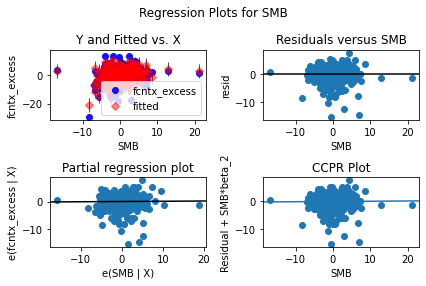

In [167]:
fig = sm.graphics.plot_regress_exog(ff_model, 'SMB')
fig.tight_layout(pad=1.0)

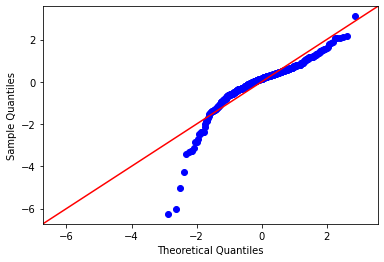

In [168]:
fig = sm.qqplot(ff_model.resid, fit=True, line="45")

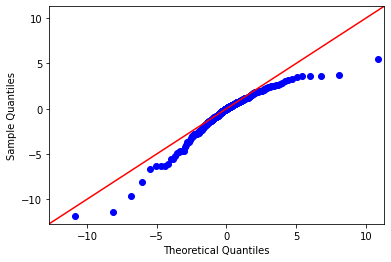

In [170]:
fig = sm.qqplot(ff_model.resid, stats.t, fit=True, line="45")

It looks like that our linear regression model is heteroskedastic. We could run the test. 

In [176]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic','F-Test p-value']
white_test = het_white(ff_model.resid, ff_model.model.exog)
dict(zip(labels, white_test))

{'LM Statistic': 45.52816733829875,
 'LM-Test p-value': 7.366460065671408e-07,
 'F-Statistic': 5.473304625777053,
 'F-Test p-value': 3.6224462917258715e-07}

Heteroskedasticity is indicated if p <0.05, so according to these tests, this model is heteroskedastic.

<AxesSubplot:>

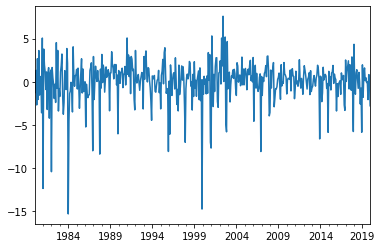

In [186]:
ff_model.resid.plot()

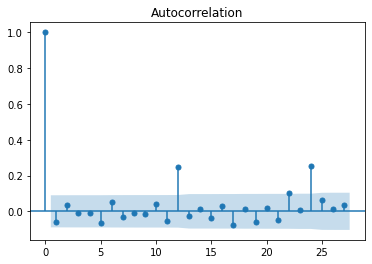

In [188]:
# check the autocorrelation of resid
fig = sm.graphics.tsa.plot_acf(ff_model.resid)

In [207]:
# extract rho and sigma
rho, sigma = sm.regression.yule_walker(ff_model.resid)
sigma

2.4393172374373226

In [200]:
# run GLS model
ff_gls = smf.glsar('fcntx_excess ~ mkt_excess + SMB + HML', data=dataset).fit()
ff_gls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:           fcntx_excess   R-squared:                       0.724
Model:                          GLSAR   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     414.6
Date:                Tue, 30 Mar 2021   Prob (F-statistic):          4.33e-132
Time:                        15:31:56   Log-Likelihood:                -1105.8
No. Observations:                 478   AIC:                             2220.
Df Residuals:                     474   BIC:                             2236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1808      0.115     -1.579      0.115      -0.406       0.044
mkt_excess     0.8783      0.027     32.636      0.000       0.825       0.931
SMB            0.0083      0.040      0.208      0.835      -0.070       0.086
HML           -0.1051      0.041     -2.579      0.010      -0.185      -0.025
==============================================================================
Omnibus:                      224.651   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1602.671
Skew:                          -1.908   Prob(JB):                         0.00
Kurtosis:                      11.119   Cond. No.                         4.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

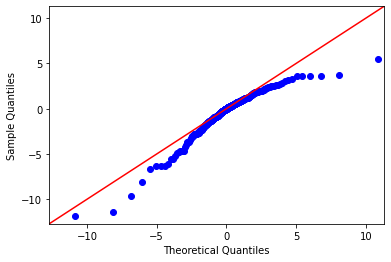

In [202]:
fig = sm.qqplot(ff_gls.resid, stats.t, fit=True, line="45")

The Fama French 3-factor model is not a good one in terms of goodness of fit. 